In [1]:
import pandas as pd

# TODO: update for state
STATE = 'il'
YEARS = [str(yr) for yr in range(2013, 2021)]

In [2]:
"""
File naming convension for ACS 5-year downloads:
state_year_[race|income].csv

"""

def get_filepath(state):
    return '../data/{state}/'.format(state=state)

def get_fname(state, year, dataset_type):
    return '{state}_{year}_{dataset_type}.csv'.format(
        state=state, year=year, dataset_type=dataset_type)

def get_filename(state, year, dataset_type):
    return get_filepath(state) + get_fname(state, year, dataset_type)


# geoid is the column we join data on
geoid_column_name = 'geoid'

geoid_column_map = {
    'GEO.id2': geoid_column_name,
    'GEO_ID': geoid_column_name
}

# for some reason particular file(s) have different column names- WHY?!
filename_income_column_map = {
    'ma_2017_income.csv': {
        'HC03_EST_VC02': 'median income',
        'HC03_MOE_VC02': 'median income margin of error',
        'HD01_VD01': 'median income',
        'HD02_VD01': 'median income margin of error'
    }
}
# Here is the default
income_column_map = {
    'HC02_EST_VC02': 'median income',
    'HC02_MOE_VC02': 'median income margin of error',
    'HD01_VD01': 'median income',
    'HD02_VD01': 'median income margin of error'
}

new_income_map = {
    'S1903_C03_001E': 'median income',
    'S1903_C03_001M': 'median income margin of error'
}

new_income_map_early = {
    'S1903_C02_001E': 'median income',
    'S1903_C02_001M': 'median income margin of error'
}

race_column_map = {
    'HD01_VD01': 'race: total households',
    'HD02_VD01': 'race: total households margin of error',
    'HD01_VD02': 'race: White',
    'HD01_VD03': 'race: Black',
    'HD01_VD05': 'race: Asian',
    'HD01_VD08': 'race: 2 or more races',
    # The following are combined into one value
    # 'HD01_VD04': 'race: American Indian and Alaska',
    # 'HD01_VD06': 'race: Native Hawaiian and Other',
    'HD01_VD07': 'race: Other',
}

new_race_column_map = {
    'B02001_001E': 'race: total households',
    'B02001_001M': 'race: total households margin of error',
    'B02001_002E': 'race: White',
    'B02001_003E': 'race: Black',
    'B02001_005E': 'race: Asian',
    'B02001_008E': 'race: 2 or more races',
    'B02001_007E': 'race: Other'
}

def race_combine_other(row):
    
    """Combines the values for the other races with american indian, hawaiian, etc"""
    try:
        return int(row['HD01_VD04']) + int(row['HD01_VD06']) + int(row['HD01_VD07'])
    except:
        return int(row['B02001_004E']) + int(row['B02001_006E']) + int(row['B02001_007E'])

def col_name_for_year(year, col_name):
    return str(year) + ' ' + col_name

def remove_labels(df):
    # drop the first row (the first row is a display label)
    df.drop([0], inplace=True)

def preprocess_df(df, year, column_map):
    # prune data
    #data from 2018-onwards only has GEO_ID not GEO.id2
    # if int(year) >= 2017:
    #     for num in range(1, df.shape[0]+1):
    #         df.at[num, 'GEO_ID'] = df.at[num, 'GEO_ID'][-11:]
    for num in range(1, df.shape[0]+1):
        df.at[num, 'GEO_ID'] = df.at[num, 'GEO_ID'][-11:]  
    # rename columns
    column_name_map = {key: col_name_for_year(year, value) for key, value in column_map.items()}
    
    column_name_map.update(geoid_column_map)
    cols_to_drop = [col for col in df.columns if not col in column_name_map.keys()]

    df.drop(cols_to_drop,  axis=1,  inplace=True)
    df.rename(columns=column_name_map, inplace=True)
    df.set_index(geoid_column_name, inplace=True)
    return df


def get_race_df(state, year):
    filename = get_filename(STATE, year, 'race')
    df = pd.read_csv(filename)
    remove_labels(df)
    df['column'] = df.apply(race_combine_other, axis=1)
    if int(year) >= 2010:
        map = new_race_column_map
    else:
        map = race_column_map
    return preprocess_df(df, year, map)


def get_income_df(state, year):
    # so annoying that the columns change with files!
    if int(year) >= 2017:
        map = new_income_map
    else:
        map = new_income_map_early
    fname = get_fname(state, year, 'income')
    print('filename', fname)
    if fname in filename_income_column_map:
        map = filename_income_column_map[fname]
    df = pd.read_csv(get_filename(STATE, year, 'income'))
    print('income:df', df)
    remove_labels(df)
    return preprocess_df(df, year, map)


In [3]:
# We merge data into the income df

def add_df(df1, df2):
    # comebine the df's on geoid
    return pd.concat([df1, df2], axis=1, join='inner')

state_df = None
for year in YEARS:
    print('handling files for year ', year)
    income_df = get_income_df(STATE, year)
    if state_df is None:
        state_df = income_df
    else:
        state_df = add_df(state_df, income_df)
    # print(state_df)
    race_df = get_race_df(STATE, year)
    state_df = add_df(state_df, race_df)
# state_df = state_df.loc[state_df[geoid_column_name] == '48201410802']
state_df.head()



handling files for year  2013
filename il_2013_income.csv
income:df                     GEO_ID                                        NAME  \
0                       id                        Geographic Area Name   
1     1400000US17031010100     Census Tract 101, Cook County, Illinois   
2     1400000US17031010201  Census Tract 102.01, Cook County, Illinois   
3     1400000US17031010202  Census Tract 102.02, Cook County, Illinois   
4     1400000US17031010300     Census Tract 103, Cook County, Illinois   
...                    ...                                         ...   
1315  1400000US17031843800    Census Tract 8438, Cook County, Illinois   
1316  1400000US17031843900    Census Tract 8439, Cook County, Illinois   
1317  1400000US17031980000    Census Tract 9800, Cook County, Illinois   
1318  1400000US17031980100    Census Tract 9801, Cook County, Illinois   
1319  1400000US17031990000    Census Tract 9900, Cook County, Illinois   

                   S1903_C01_001E          

,2013 median income,2013 median income margin of error,2013 race: total households,2013 race: total households margin of error,2013 race: White,2013 race: Black,2013 race: Asian,2013 race: Other,2013 race: 2 or more races,2014 median income,...,2019 race: 2 or more races,2020 median income,2020 median income margin of error,2020 race: total households,2020 race: total households margin of error,2020 race: White,2020 race: Black,2020 race: Asian,2020 race: Other,2020 race: 2 or more races
geoid,,,,,,,,,,,,,,,,,,,,,
17031010100,32191,7416,5068,641,2233,2328,232,69,206,30798,...,155,42891,22191,4644,721,2430,1649,91,248,226
17031010201,39908,4643,7316,809,2809,3399,362,541,195,40532,...,599,39955,23269,7488,1046,3003,2646,426,615,788
17031010202,36315,13128,2583,380,1357,832,46,167,157,25250,...,40,43839,6338,3154,445,1282,1031,198,551,62
17031010300,43483,9770,6065,741,3212,1606,858,284,99,42606,...,275,44375,16139,6135,1116,3249,1802,148,716,204
17031010400,41765,10061,4694,488,3431,682,313,119,149,38531,...,95,37198,8616,5193,684,3843,972,229,87,62


In [4]:
# Save the giant dataframe to CSV
output_csvfilename = get_filepath(STATE) + 'race_and_income_data.csv'
state_df.to_csv(output_csvfilename)
print('saved data to ',  output_csvfilename)

saved data to  ../data/il/race_and_income_data.csv


In [5]:
import geopandas as gpd

In [9]:
"""Creates shapefile from NYC open data download.
This shapefile does not have geoids, so must add them based on its other data.

"""

NY_STATE_CODE = '36'

nyc_shapefile_attributes = {
    geoid_column_name: geoid_column_name,
    'ntaname': 'Name', # name of neighborhood in this dataset
    # Tracts are duplicated across boros.
    # The unique key is 'boro_ct201' which is the concatenation of boro id and ct
    # 'ct2010': 'tract',
    'shape_area': 'shape_area',
    'shape_leng': 'shape_leng',
    'geometry': 'geometry'
}
ma_shapefile_attributes = {
    'GEOID10': geoid_column_name,
    'NAMELSAD10': 'Name', # 'Census Tract ###'  in this dataset
    'SHAPE_AREA': 'shape_area',
    'SHAPE_LEN': 'shape_leng',
    'geometry': 'geometry'
}

hou_shapefile_attributes = {
    'GEOID': geoid_column_name,
    'NAMELSAD': 'Name',
    'AREA': 'shape_area',
    'geometry': 'geometry'
}

# Mapping of boro names to county code for geoid
# Taken from wikipedia info: https://en.wikipedia.org/wiki/List_of_counties_in_New_York
nyc_boro_to_county_code = {
    'Bronx':'005',
    'Queens':'081',
    'Brooklyn':'047',
    'Manhattan':'061',
    'Staten Island':'085'
}


def get_nyc_shapefile():
    shapefile_filename = get_filepath('ny') + 'city_census_tracts_shapefile/geo_export_6f3df1e4-1be2-4395-ba6c-3e15b0a10221.shp'
    shapefile_df = gpd.read_file(shapefile_filename)
    shapefile_df[geoid_column_name] = shapefile_df.apply(get_nyc_geoid, axis=1)
    return shapefile_df


def get_nyc_county_code(row):
    boro_name = row['boro_name']
    return nyc_boro_to_county_code[boro_name]


def get_nyc_geoid(row):
    state_code = NY_STATE_CODE
    county_code = get_nyc_county_code(row)
    tract_code = row['ct2010']
    return str(state_code) + str(county_code) + str(tract_code)

shapefile_df = None
if STATE == 'ny':
    shapefile_df = get_nyc_shapefile()
    shapefile_attributes = nyc_shapefile_attributes
elif STATE == 'ma':
    shapefile_filename = get_filepath(STATE) + 'shapefile/boston-brookline-cambridge-somerville-everett.shp'
    shapefile_df = gpd.read_file(shapefile_filename)
    shapefile_attributes = ma_shapefile_attributes
elif STATE == 'tx':
    shapefile_filename = get_filepath(STATE) + 'shapefiles/tl_2021_48_tract.shp'
    shapefile_df = gpd.read_file(shapefile_filename)
    shapefile_df = shapefile_df.loc[shapefile_df["COUNTYFP"] == '201']
    shapefile_df["AREA"] = shapefile_df["ALAND"].astype(int) + shapefile_df["AWATER"].astype(int)
    shapefile_attributes = hou_shapefile_attributes
elif STATE == 'dc':
    shapefile_filename = get_filepath(STATE) + 'shapefile/DC/tl_2021_11_tract.shp'
    dc_shapefile_df = gpd.read_file(shapefile_filename)

    shapefile_filename = get_filepath(STATE) + 'shapefile/MD/tl_2021_24_tract.shp'
    md_shapefile_df = gpd.read_file(shapefile_filename)
    md_shapefile_df1 = md_shapefile_df.loc[md_shapefile_df["COUNTYFP"] == '031']
    md_shapefile_df2 = md_shapefile_df.loc[md_shapefile_df["COUNTYFP"] == '033']
    md_shapefile_df = pd.concat([md_shapefile_df1, md_shapefile_df2], axis = 0)

    shapefile_filename = get_filepath(STATE) + 'shapefile/VA/tl_2021_51_tract.shp'
    va_shapefile_df = gpd.read_file(shapefile_filename)
    va_shapefile_df1 = va_shapefile_df.loc[va_shapefile_df["COUNTYFP"] == '013']
    va_shapefile_df2 = va_shapefile_df.loc[va_shapefile_df["COUNTYFP"] == '510']
    va_shapefile_df = pd.concat([va_shapefile_df1, va_shapefile_df2], axis = 0)

    shapefile_df = pd.concat([dc_shapefile_df, va_shapefile_df, md_shapefile_df], axis = 0)
    shapefile_df["AREA"] = shapefile_df["ALAND"].astype(int) + shapefile_df["AWATER"].astype(int)
    shapefile_attributes = hou_shapefile_attributes

elif STATE == 'il':
    shapefile_filename = get_filepath(STATE) + 'shapefile/tl_2021_17_tract.shp'
    shapefile_df = gpd.read_file(shapefile_filename)
    shapefile_df = shapefile_df.loc[shapefile_df["COUNTYFP"] == '031']
    shapefile_df["AREA"] = shapefile_df["ALAND"].astype(int) + shapefile_df["AWATER"].astype(int)
    shapefile_attributes = hou_shapefile_attributes

shapefile_df


,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,AREA
54,17,031,221000,17031221000,2210,Census Tract 2210,G5020,S,220053,0,+41.9209604,-087.7152526,"POLYGON ((-87.71699 41.92460, -87.71675 41.924...",220053
55,17,031,221100,17031221100,2211,Census Tract 2211,G5020,S,440042,0,+41.9210205,-087.7103609,"POLYGON ((-87.71374 41.92464, -87.71366 41.924...",440042
56,17,031,242800,17031242800,2428,Census Tract 2428,G5020,S,439630,0,+41.8926320,-087.6903237,"POLYGON ((-87.69670 41.89565, -87.69646 41.895...",439630
57,17,031,242900,17031242900,2429,Census Tract 2429,G5020,S,323819,0,+41.8921955,-087.6842896,"POLYGON ((-87.68684 41.89574, -87.68635 41.895...",323819
58,17,031,243000,17031243000,2430,Census Tract 2430,G5020,S,324547,0,+41.8922753,-087.6793981,"POLYGON ((-87.68195 41.89583, -87.68146 41.895...",324547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3210,17,031,050300,17031050300,503,Census Tract 503,G5020,S,380031,14700,+41.9578851,-087.6904442,"POLYGON ((-87.69476 41.96127, -87.69460 41.961...",394731
3218,17,031,830700,17031830700,8307,Census Tract 8307,G5020,S,861986,7945,+41.9583035,-087.6607646,"POLYGON ((-87.66595 41.96164, -87.66575 41.961...",869931
3219,17,031,834700,17031834700,8347,Census Tract 8347,G5020,S,657991,0,+41.7906903,-087.6450334,"POLYGON ((-87.65002 41.79424, -87.64986 41.794...",657991
3254,17,031,824123,17031824123,8241.23,Census Tract 8241.23,G5020,S,3917329,25455,+41.5898448,-087.7989125,"POLYGON ((-87.81369 41.60198, -87.81287 41.601...",3942784


In [10]:
# Map column names and remove columns
shapefile_cols_to_drop = [col for col in shapefile_df.columns if not col in shapefile_attributes.keys()]
shapefile_df.drop(shapefile_cols_to_drop,  axis=1,  inplace=True)
shapefile_df.rename(columns=shapefile_attributes, inplace=True)
shapefile_df.set_index(geoid_column_name, inplace=True)
shapefile_df.head() 



,Name,geometry,shape_area
geoid,,,
17031221000,Census Tract 2210,"POLYGON ((-87.71699 41.92460, -87.71675 41.924...",220053
17031221100,Census Tract 2211,"POLYGON ((-87.71374 41.92464, -87.71366 41.924...",440042
17031242800,Census Tract 2428,"POLYGON ((-87.69670 41.89565, -87.69646 41.895...",439630
17031242900,Census Tract 2429,"POLYGON ((-87.68684 41.89574, -87.68635 41.895...",323819
17031243000,Census Tract 2430,"POLYGON ((-87.68195 41.89583, -87.68146 41.895...",324547


c:\Users\Walter\anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<AxesSubplot:>

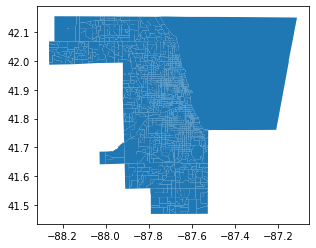

In [11]:
# Want projection CRS84 which is equivalent to EPSG:4326
shapefile_df = shapefile_df.to_crs({'init': 'epsg:4326'})

%matplotlib inline
shapefile_df.plot()

In [12]:
merged_shapes = shapefile_df.merge(state_df, on=geoid_column_name)
print('shape', merged_shapes.shape)
merged_shapes.head()

shape (1288, 75)


,Name,geometry,shape_area,2013 median income,2013 median income margin of error,2013 race: total households,2013 race: total households margin of error,2013 race: White,2013 race: Black,2013 race: Asian,...,2019 race: 2 or more races,2020 median income,2020 median income margin of error,2020 race: total households,2020 race: total households margin of error,2020 race: White,2020 race: Black,2020 race: Asian,2020 race: Other,2020 race: 2 or more races
geoid,,,,,,,,,,,,,,,,,,,,,
17031221000,Census Tract 2210,"POLYGON ((-87.71699 41.92460, -87.71675 41.924...",220053,42637,13177,3271,361,2595,356,17,...,27,83295,13862,2754,443,2246,147,73,219,59
17031221100,Census Tract 2211,"POLYGON ((-87.71374 41.92464, -87.71365 41.924...",440042,46964,10280,4815,541,3545,644,89,...,130,74931,13257,4484,540,3332,356,212,251,316
17031242800,Census Tract 2428,"POLYGON ((-87.69670 41.89565, -87.69645 41.895...",439630,59185,14721,1547,195,1348,9,43,...,24,122650,40506,1637,247,1434,7,45,142,3
17031242900,Census Tract 2429,"POLYGON ((-87.68684 41.89574, -87.68635 41.895...",323819,50052,11723,1947,222,1421,109,25,...,164,110375,29561,1836,292,1267,126,103,48,292
17031243000,Census Tract 2430,"POLYGON ((-87.68195 41.89583, -87.68146 41.895...",324547,68550,15365,2496,347,2172,2,51,...,52,89196,25273,2134,383,1517,25,65,421,96


In [13]:
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

In [14]:
to_filename = get_filepath(STATE) + STATE  + '_census_tracts.geojson'
print('saving to ',to_filename)
merged_shapes["geometry"] = [MultiPolygon([feature]) if type(feature) == Polygon \
    else feature for feature in merged_shapes["geometry"]]
merged_shapes.to_file(to_filename, driver='GeoJSON')
print('saved')
sort = False

saving to  ../data/il/il_census_tracts.geojson
saved
